In [2]:
import dbcp
from dbcp.extract.gridstatus_isoqueues import ISO_QUEUE_VERSIONS
import pandas as pd

/app/.local/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.4-CAPI-1.17.4) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(
/app/.local/lib/python3.10/site-packages/pudl/analysis/spatial.py:7: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/

{'miso': '1728242350923420',
 'miso-pre-2017': '1709776311574737',
 'caiso': '1728242351254356',
 'pjm': '1728242351606642',
 'ercot': '1728242351929200',
 'spp': '1728242352244156',
 'nyiso': '1728242352584485',
 'isone': '1728242352913470'}

## Get latest generation number for archives
Each time the [gridstatus archiver](https://github.com/deployment-gap-model-education-fund/deployment-gap-model-archiver) is run, GCS creates a new generation number for the new version of the data. The follow code grabs the latest generation number of the interconneciton queue data for each ISO.

In [159]:
from google.cloud import storage
from datetime import datetime

def get_generation_number_closest_to_date(bucket_name, blob_name, target_date):
    client = storage.Client()
    bucket = client.bucket(bucket_name)

    # Enable listing versions of the blob
    blobs = bucket.list_blobs(prefix=blob_name, versions=True)

    # Filter and sort blobs by time difference
    closest_blob = None
    min_time_diff = float('inf')
    target_timestamp = target_date.timestamp()
    
    blobs = sorted(blobs, key=lambda blob: blob.updated.timestamp())

    for blob in blobs:
        # Get the last modified time and calculate difference from target date
        last_modified = blob.updated.timestamp()

        if target_timestamp < last_modified:
            print(blob.updated)
            return str(blob.generation)

# Example usage
bucket_name = "dgm-archive"
target_date = datetime(2024, 9, 30)  # Specify the date you want to find closest to

updated_iso_queue_version = ISO_QUEUE_VERSIONS.copy()

for iso_region in ISO_QUEUE_VERSIONS.keys():
    if iso_region == "miso-pre-2017":
        continue
    blob_name = f"gridstatus/interconnection_queues/parquet/{iso_region}.parquet"
    updated_iso_queue_version[iso_region] = get_generation_number_closest_to_date(bucket_name, blob_name, target_date)


2024-10-06 19:19:11.021000+00:00
2024-10-06 19:19:11.349000+00:00
2024-10-06 19:19:11.701000+00:00
2024-10-06 19:19:12.020000+00:00
2024-10-06 19:19:12.340000+00:00
2024-10-06 19:19:12.683000+00:00
2024-10-06 19:19:13.005000+00:00


In [160]:
updated_iso_queue_version

{'miso': '1728242350923420',
 'miso-pre-2017': '1709776311574737',
 'caiso': '1728242351254356',
 'pjm': '1728242351606642',
 'ercot': '1728242351929200',
 'spp': '1728242352244156',
 'nyiso': '1728242352584485',
 'isone': '1728242352913470'}

Copy and past the old version numbers from `dbcp.extract.gridstatus_isoqueues.ISO_QUEUE_VERSIONS`.

In [162]:
old_queue_version = {'miso': '1719774997006069',
 'miso-pre-2017': '1709776311574737',
 'caiso': '1719774997530790',
 'pjm': '1719774998059470',
 'ercot': '1719774998544416',
 'spp': '1719774998998901',
 'nyiso': '1719774999497797',
 'isone': '1719774999940225'}

In [163]:
old_iso_queues = dbcp.extract.gridstatus_isoqueues.extract(old_queue_version)
new_iso_queues = dbcp.extract.gridstatus_isoqueues.extract(updated_iso_queue_version)

## Compare max dates of raw data
The follow code prints out the latest date a project entered a queue for each ISO in the old and new data. We should expect the latest project date in the new data to be larger than the that of the old data. There are currently two exceptions to this:

1. CAISO: We haven't been able to figure out how CAISO publishes data about active projects in the interconneciton queue. The CAISO data from Gridstatus rarely updates so we rely on the LBNL data.
2. PJM: PJM [is working through a backlog of projects](https://www.utilitydive.com/news/pjm-fast-track-reliability-projects-interconnection-queue-invenergy/729311/) and isn't accepting new projects until mid 2026.

In [166]:
for iso_region in old_iso_queues.keys():
    if iso_region == "miso-pre-2017":
        continue
    print(iso_region)
    old_df = old_iso_queues[iso_region]
    new_df = new_iso_queues[iso_region]
    
    old_df['Queue Date'] = pd.to_datetime(old_df['Queue Date'])
    new_df['Queue Date'] = pd.to_datetime(new_df['Queue Date'])
    
    print(f" - Old max date {old_df['Queue Date'].max()}")
    print(f" - New max date {new_df['Queue Date'].max()}")
    print()

miso
 - Old max date 2024-06-07 04:00:00+00:00
 - New max date 2024-09-27 04:00:00+00:00

caiso
 - Old max date 2023-03-02 08:00:00
 - New max date 2023-03-02 08:00:00

pjm
 - Old max date 2023-07-08 00:00:00
 - New max date 2023-07-08 00:00:00

ercot
 - Old max date 2024-05-20 00:00:00
 - New max date 2024-09-10 00:00:00

spp
 - Old max date 2024-05-07 00:00:00
 - New max date 2024-08-02 00:00:00

nyiso
 - Old max date 2024-05-23 00:00:00
 - New max date 2024-08-05 00:00:00

isone
 - Old max date 2024-06-26 00:00:00
 - New max date 2024-08-21 00:00:00



## Compare data mart tables
The follow code compares the old and new total active capacity in regions.

### How to grab the new data
To get the new data, replace `dbcp.extract.gridstatus_isoqueues.ISO_QUEUE_VERSIONS` with the updated generation numbers. Then run `make all`. There might be some data validation errors due to small changes in the expected number of projects. If the changes seem reasonable, just update the expected value in the assertion. If they don't seem reason, do some digging!

Once the ETL succesfully finishes the new data is available in the databse.

<!-- - download the `dev` data to compare to
- load the relevent tables

data warehouse
- check the old and new iso have a similar n and capacity
- plot total capacity


data mart:
- total capacity, n_projects and max date have all the same: caiso, ercot, pjm
- total capacity, n_projects and max date have all increased: miso, pjm, spp, nyiso, isone
- withdrawn and in service capacity have increased: miso, pjm, spp, nyiso, isone

- active capacity has changed for isos in GS_REGIONS
- how much has the active capacity changed by? -->

In [175]:
from dbcp.helpers import get_sql_engine

engine = get_sql_engine()
with engine.connect() as con:
    new_iso_projects_long_format = pd.read_sql_table("iso_projects_long_format", con, schema="data_mart")

### How to grab the old data
To grab the "old" data you'll need to download the latest version of the development outputs from GCS. Currently, we don't version the data that is saved to `gs://dgm-outputs/dev` so I'd recommend naming the subdirectory you save the outputs to with the github sha that was used to produce the outputs. You can find the appropriate git sha by viewing [this list](https://github.com/deployment-gap-model-education-fund/deployment-gap-model/actions/workflows/run-full-build.yml?query=branch%3Adev) of github action runs that produced the development data on GCS.

From the root of this directory you can run this command to download all the development outputs:

```bash
gsutil -m cp -r gs://dgm-outputs/dev notebooks/data_updates/outputs/{gitsha of recent dev build or current date}
```

In [177]:
output_id = "a0fc9e0" # replace with the unique ID you choose to store the dev outputs locally
old_iso_projects_long_format = pd.read_parquet(f"../outputs/{output_id}/dev/data_mart/iso_projects_long_format.parquet")

In [178]:
def agg_iso_projects_long_format(df):
    """Calculate some aggregate metrics for each ISO"""
    agg = df.groupby("iso_region").agg({"surrogate_id": "count", "capacity_mw": "sum", "date_entered_queue": "max"})
    agg = agg.rename(columns={"surrogate_id": "n_projects", "capacity_mw": "total_capacity_mw", "date_entered_queue": "max_date_entered_queue"})
    return agg

old_project_agg = agg_iso_projects_long_format(old_iso_projects_long_format)
new_project_agg = agg_iso_projects_long_format(new_iso_projects_long_format)

In [179]:
new_project_agg.max_date_entered_queue

iso_region
CAISO                 2023-04-17 00:00:00
ERCOT                 2024-09-10 00:00:00
ISONE                 2024-08-21 00:00:00
MISO                  2024-09-27 04:00:00
NYISO                 2024-08-05 00:00:00
PJM                   2023-07-08 00:00:00
SPP                   2024-08-02 00:00:00
Southeast (non-ISO)   2023-12-15 00:00:00
West (non-ISO)        2023-12-30 00:00:00
Name: max_date_entered_queue, dtype: datetime64[ns]

In [180]:
both_project_aggs = old_project_agg.merge(new_project_agg, left_index=True, right_index=True, validate="1:1", suffixes=("_old", "_new"))
both_project_aggs

,n_projects_old,total_capacity_mw_old,max_date_entered_queue_old,n_projects_new,total_capacity_mw_new,max_date_entered_queue_new
iso_region,,,,,,
CAISO,1410,500444.8000,2023-04-17 00:00:00,1410,500444.8000,2023-04-17 00:00:00
ERCOT,1524,303194.4700,2024-05-20 00:00:00,1605,322303.2000,2024-09-10 00:00:00
ISONE,529,71354.4190,2024-06-26 00:00:00,503,60720.3512,2024-08-21 00:00:00
MISO,2226,382090.3300,2024-06-07 04:00:00,2186,378040.1000,2024-09-27 04:00:00
NYISO,237,27591.4800,2024-05-21 00:00:00,198,24891.9000,2024-08-05 00:00:00
PJM,2664,203395.8968,2023-07-08 00:00:00,2569,203615.4318,2023-07-08 00:00:00
SPP,624,123440.9620,2024-05-07 00:00:00,610,121268.0020,2024-08-02 00:00:00
Southeast (non-ISO),1072,136024.0300,2023-12-15 00:00:00,1072,136024.0300,2023-12-15 00:00:00
West (non-ISO),2542,488401.0500,2023-12-30 00:00:00,2542,488401.0500,2023-12-30 00:00:00


In [181]:
# Calculate the differences between the old and new
for col in old_project_agg.columns:
    if pd.api.types.is_datetime64_any_dtype(old_project_agg[col]):
        continue
    else:
        both_project_aggs[f"{col}_pct_diff"] = (both_project_aggs[f"{col}_new"] - both_project_aggs[f"{col}_old"]) / both_project_aggs[f"{col}_old"]

In [182]:
old_project_agg

both_project_aggs.sort_values(by="total_capacity_mw_old", ascending=False)[["n_projects_pct_diff", "total_capacity_mw_pct_diff"]] * 100

,n_projects_pct_diff,total_capacity_mw_pct_diff
iso_region,,
CAISO,0.000000,0.000000
West (non-ISO),0.000000,0.000000
MISO,-1.796945,-1.060019
ERCOT,5.314961,6.302467
PJM,-3.566066,0.107935
Southeast (non-ISO),0.000000,0.000000
SPP,-2.243590,-1.760323
ISONE,-4.914934,-14.903166
NYISO,-16.455696,-9.784107


We don't use Gridstatus for CAISO for the reasons stated above so we filter it out in this analysis.

In [183]:
from dbcp.data_mart.projects import GS_REGIONS

changed_project_aggs = both_project_aggs[both_project_aggs.index.isin(GS_REGIONS)]

changed_project_aggs

,n_projects_old,total_capacity_mw_old,max_date_entered_queue_old,n_projects_new,total_capacity_mw_new,max_date_entered_queue_new,n_projects_pct_diff,total_capacity_mw_pct_diff
iso_region,,,,,,,,
ERCOT,1524,303194.4700,2024-05-20 00:00:00,1605,322303.2000,2024-09-10 00:00:00,0.053150,0.063025
ISONE,529,71354.4190,2024-06-26 00:00:00,503,60720.3512,2024-08-21 00:00:00,-0.049149,-0.149032
MISO,2226,382090.3300,2024-06-07 04:00:00,2186,378040.1000,2024-09-27 04:00:00,-0.017969,-0.010600
NYISO,237,27591.4800,2024-05-21 00:00:00,198,24891.9000,2024-08-05 00:00:00,-0.164557,-0.097841
PJM,2664,203395.8968,2023-07-08 00:00:00,2569,203615.4318,2023-07-08 00:00:00,-0.035661,0.001079
SPP,624,123440.9620,2024-05-07 00:00:00,610,121268.0020,2024-08-02 00:00:00,-0.022436,-0.017603


Make sure there isn't an surprising change in total capacity between the old and new data. We currently don't expect the active capacity to change that much in the span of a quarter. The `max_change` value is an arbitrary number so dig into the data if something looks fishy to you.

It's challenging to validate total capacity changes in ISOs. If there is an unexpected change, I would check the ISO's website to see if they changed their study process. For example, there was a surprising drop in active capacity in NYISO during the 2024 Q4 update. It turns out they [changed their study process](https://www.utilitydive.com/news/new-york-iso-reforms-interconnection-queue-launches-cluster-study/724054/) and the layout of the spreadsheet Gridstatus pulls in. Sites like S&P and Utility Drive might have relevant informaiton.

In [186]:
mw_pct_diff = changed_project_aggs["total_capacity_mw_pct_diff"].abs()
max_change = 0.2
assert mw_pct_diff.lt(max_change).all(), f"{mw_pct_diff} substantial change in an ISO's interconneciton queue active capacity."

## Charts
The `iso_regions_active_projects_capacity_mw_change_log` data mart table contains historic snapshots of total active capacity in the ISO queues. Ploting the change over time if helpful for identifying issues with the data update.

In [187]:
with engine.connect() as con:
    iso_regions_active_projects_capacity_mw_change_log = pd.read_sql_table("iso_regions_active_projects_capacity_mw_change_log", con, schema="data_mart")

In [188]:
iso_regions_active_projects_capacity_mw_change_log.groupby("iso_region").report_date.max()

iso_region
CAISO   2024-09-30
ISONE   2024-09-30
MISO    2024-09-30
NYISO   2024-09-30
PJM     2027-09-30
SPP     2024-09-30
Name: report_date, dtype: datetime64[ns]

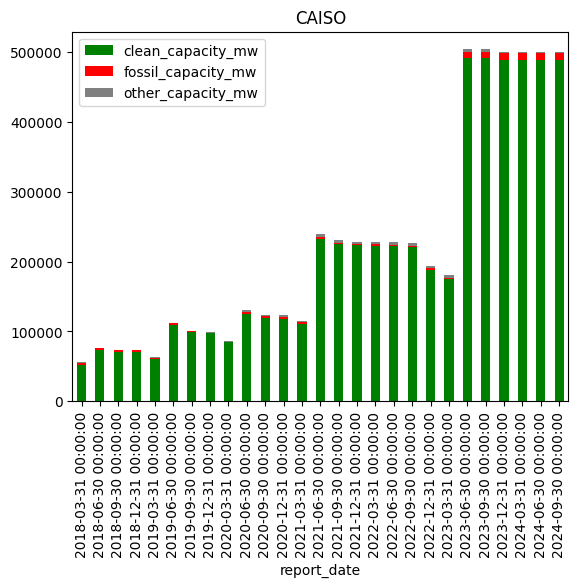

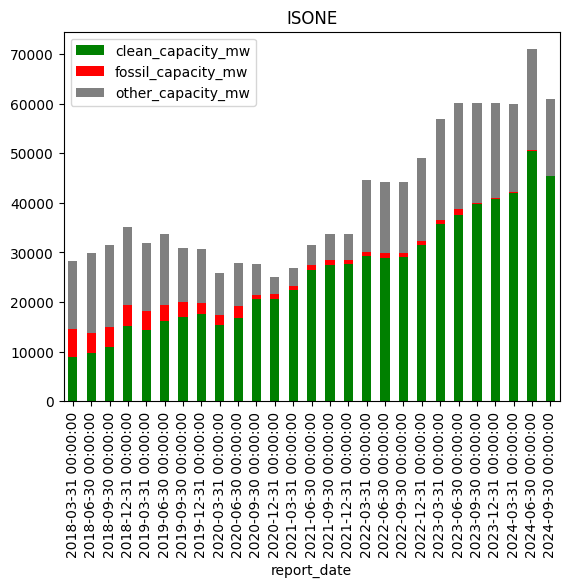

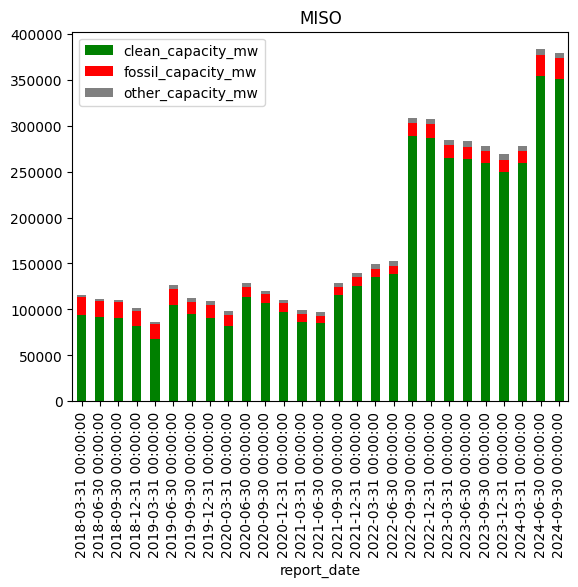

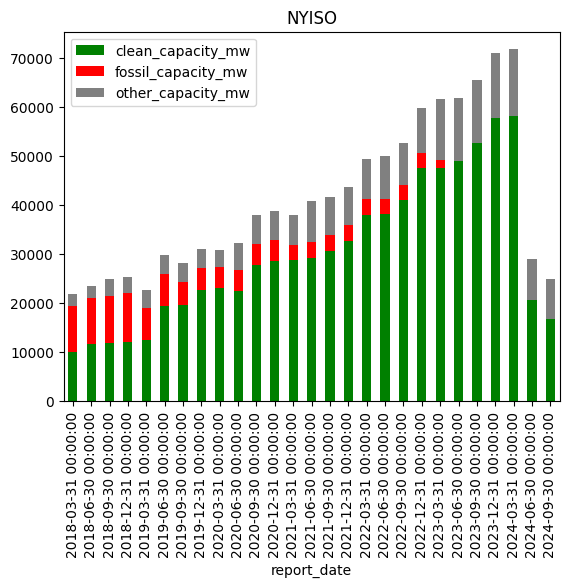

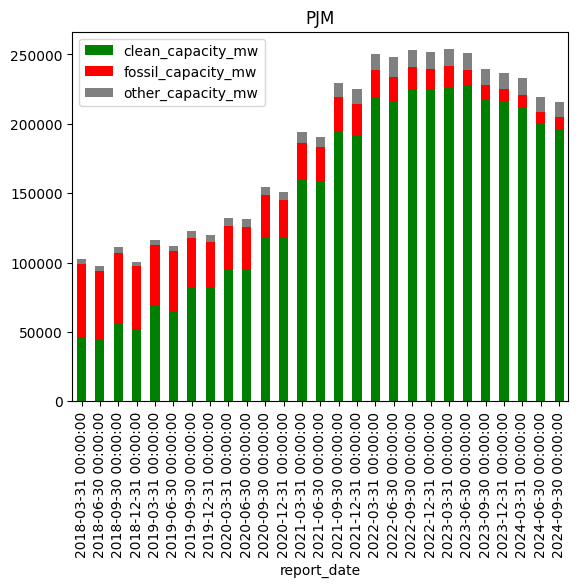

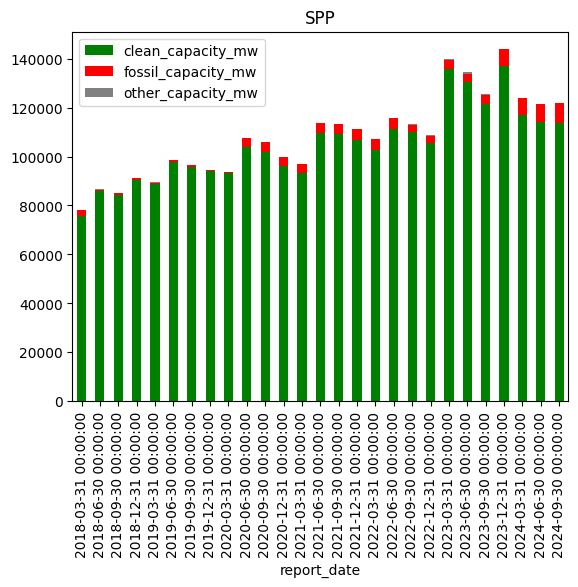

In [189]:
chnglog = iso_regions_active_projects_capacity_mw_change_log.groupby(["iso_region", "report_date"]).sum().reset_index()

for iso_region in chnglog.iso_region.unique():
    iso_df = chnglog.query("iso_region == @iso_region")
    iso_df = iso_df[iso_df.report_date.dt.year.gt(2017) & (iso_df.report_date < "2024-10-01")]
    iso_df = iso_df.set_index("report_date")
    iso_df.plot.bar(color=["green", "red", "grey"], title=iso_region, stacked=True)